# Machine learning model using the Titanic dataset

It provides information on the fate of passengers on the Titanic summarized according to economic status, sex and age. In this challenge, we should answer the question whether a passenger on the titanic would have been survived or not.

 #### Project from https://www.kaggle.com

In [1]:
import numpy as np 

import pandas as pd 

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [4]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

### It is always a good idea to start by exploring the data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### The training set has 891 samples and 11 features plus the target variable 'Survived'.

#### Now we can take a look at the first entries:

In [8]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### We can see that we need to convert some features into numeric ones and deal with NaN values. Features with a wide range should be normalized.

#### Some statistics about our training set:

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 38% of the training set survived. Here we can also detect some potential issues, like missing values in 'Age'.

#### A more quantitative look into what is missing:

In [43]:
total = train_df.isna().sum().sort_values(ascending=False)
percent = (train_df.isna().sum()/train_df.isna().count()*100).round(decimals=1).sort_values(ascending=False)
missing_data = pd.concat([total, percent,], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


#### Since most entries for Cabin are empty, we might discart it from the analysis.

#### Time to look for features that correlate with the survival rate. Let's start with age and sex:

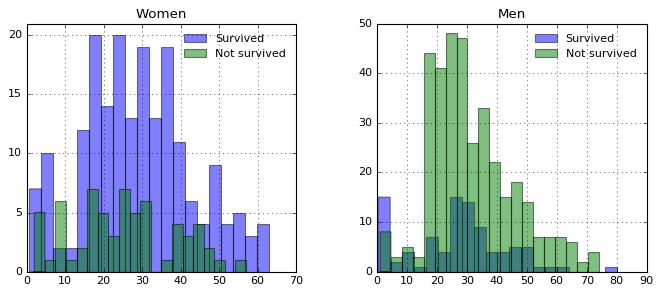

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

w_surv = women[women['Survived']==1]
w_notsurv = women[women['Survived']==0]

w_surv.hist(column='Age', ax = axes[0], bins = 20, label = 'Survived', alpha=0.5)
w_notsurv.hist(column='Age', ax = axes[0], bins = 20, label = 'Not survived', alpha=0.5)
axes[0].legend(frameon=False, fontsize = 'medium')
axes[0].set_title('Women')
axes[0].set_ylim(0, 21)

m_surv = men[men['Survived']==1]
m_notsurv = men[men['Survived']==0]

m_surv.hist(column='Age', ax = axes[1], bins = 20, label = 'Survived', alpha=0.5)
m_notsurv.hist(column='Age', ax = axes[1], bins = 20, label = 'Not survived', alpha=0.5)
axes[1].legend(frameon=False, fontsize = 'medium')
_ = axes[1].set_title('Men')
#axes[1].set_ylim(0, 50)

We can see that women have a high probability of survival between the ages 15 to 40, while for men this range is narrower. Infants also have a higher chance to survive for both genders.  

#### Now let's look for correlations between survival, embarked and class:

/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


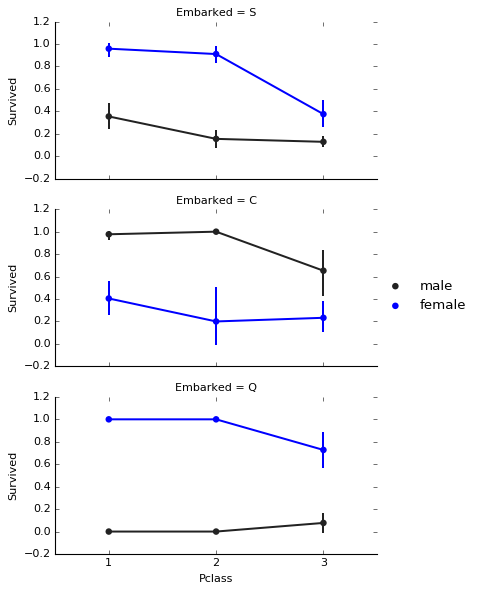

In [134]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=2.5, aspect=2)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
FacetGrid.add_legend();

Embarked shows a correlation with survival and gender. Women have a higher survival chance if embarked on ports S or Q, while men shows a better chance of surviving if embarked on port C. Pclass also shows a trend, so let's have a closer look at this feature:

/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


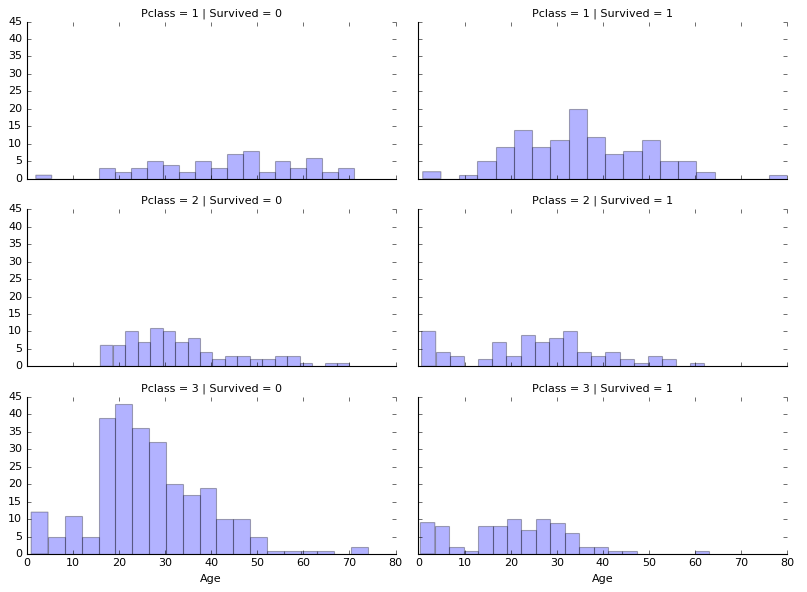

In [133]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.5, aspect=2)
grid.map(plt.hist, 'Age', alpha=0.3, bins=20)
grid.add_legend();

From the plot above we see that the probability of surviving is high for Pclass = 1, while for Pclass = 3 it is most likely that a person will not survive.